<a href="https://colab.research.google.com/github/lambertae/controlnet-demosaicing/blob/master/6_8301_final_project_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install -q diffusers==0.14.0 transformers xformers git+https://github.com/huggingface/accelerate.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 96.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.2/108.2 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.6 MB/s eta 0:00:00


In [7]:
!pip install -q opencv-contrib-python
!pip install -q controlnet_aux

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.6 MB/s eta 0:00:00


In [8]:
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

## Visualize Data

In [1]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [86]:
import os
def load_text(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    text = text.split('\n')
    # close the file
    file.close()
    return text
text_folder = "./Flickr8k_Dataset"
train_imgs = load_text("Flickr_8k.trainImages.txt")
test_imgs = load_text("Flickr_8k.testImages.txt")
dev_imgs = load_text("Flickr_8k.devImages.txt")
train_imgs = [x for x in train_imgs if x != '']
test_imgs = [x for x in test_imgs if x != '']
dev_imgs = [x for x in dev_imgs if x != '']

In [89]:
import string
def load_descriptions(doc):
    mapping = dict()
    for line in doc:
        tokens = line.split()
        if len(tokens) < 2:
            continue
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]
        image_desc = ' '.join(image_desc)
        if image_id not in mapping.keys():
            mapping[image_id] = []
        mapping[image_id].append(image_desc)
    return mapping
def clean_description(desc_dict):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in desc_dict.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            desc = [word.lower() for word in desc]
            desc = [w.translate(table) for w in desc]
            desc = [word for word in desc if len(word)>1]
            desc_list[i] =  ' '.join(desc)
descriptions = load_text("Flickr8k.token.txt")
desc_dict = load_descriptions(descriptions)
clean_description(desc_dict)

In [90]:
# sort desc_dict[a] by the length of the sentence
for key, desc_list in desc_dict.items():
    desc_list.sort(key=lambda x: len(x), reverse=True)
print(desc_dict['1000268201_693b08cb0e'])

['child in pink dress is climbing up set of stairs in an entry way', 'little girl in pink dress going into wooden cabin', 'little girl climbing the stairs to her playhouse', 'little girl climbing into wooden playhouse', 'girl going into wooden building']


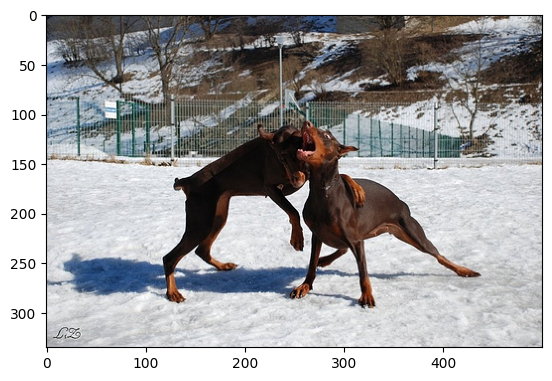

['the dogs are in the snow in front of fence', 'two brown dogs playfully fight in the snow', 'two brown dogs wrestle in the snow', 'two dogs playing in the snow', 'the dogs play on the snow']


In [98]:
img_folder = "Flicker8k_Dataset"
import cv2 
import matplotlib.pyplot as plt

cnt = 0
for name in test_imgs:
    cnt += 1
    prefix = name.split('.')[0]
    img = cv2.imread(os.path.join(img_folder, name))
    
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    
    print(desc_dict[prefix])
    if cnt == 1:
        break

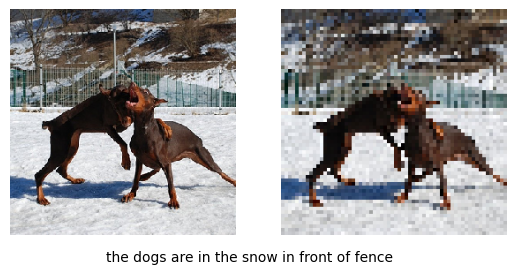

In [125]:
def load_my_image(filename):
    img = cv2.imread(os.path.join(img_folder, filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def center_crop(img):
    h, w, c = img.shape
    if h > w:
        img = img[(h-w)//2:(h-w)//2+w, :, :]
    else:
        img = img[:, (w-h)//2:(w-h)//2+h, :]
    return img

def resize(img):
    img = cv2.resize(center_crop(img), (256, 256), interpolation=cv2.INTER_NEAREST)
    return img

def pixelate(img):
    img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_NEAREST)
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_NEAREST)
    return img

file = test_imgs[0]
# plot img with pixelate(resize(img))
fig, ax = plt.subplots(1, 2)
img1 = load_my_image(file)
ax[0].imshow(resize(img1))
ax[1].imshow(pixelate(resize(img1)))
caption = desc_dict[file.split('.')[0]][0]
for a in ax:
    a.axis('off')
# show caption in plt
plt.subplots_adjust(bottom=-0.2)
fig.text(0.5, 0.05, caption, ha='center')
plt.show()

In [117]:
len(test_imgs)

1000

In [132]:
import random
def load_random_eval_image(test_imgs, visualize=True):
  random_number = random.randint(0, len(test_imgs)-1)
  file = test_imgs[random_number]
  # plot img with pixelate(resize(img))
  
  img1 = load_my_image(file)
  original_img, pixelate_img = resize(img1), pixelate(resize(img1))
  caption = desc_dict[file.split('.')[0]][0]
  
  if visualize:
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(original_img)
    ax[1].imshow(pixelate_img)
    
    for a in ax:
        a.axis('off')
    # show caption in plt
    plt.subplots_adjust(bottom=-0.2)
    fig.text(0.5, 0.05, caption, ha='center')
    plt.show()
  return original_img, pixelate_img, caption

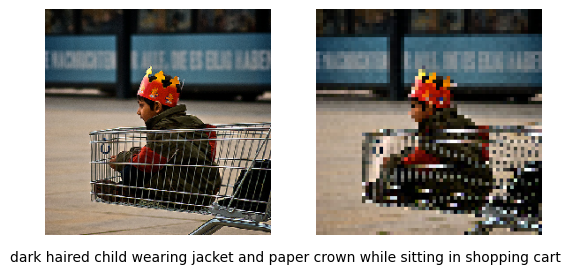

(array([[[ 40,  31,  16],
         [ 39,  30,  15],
         [ 36,  25,   5],
         ...,
         [  2,   3,   5],
         [ 11,  12,  14],
         [ 16,  17,  19]],
 
        [[ 44,  35,  20],
         [ 46,  37,  22],
         [ 52,  41,  23],
         ...,
         [  5,   6,   8],
         [  7,   8,  10],
         [  8,   9,  11]],
 
        [[ 55,  46,  29],
         [ 47,  38,  21],
         [ 57,  46,  28],
         ...,
         [  6,   8,   7],
         [  7,   8,  10],
         [ 13,  14,  16]],
 
        ...,
 
        [[151, 129, 108],
         [158, 136, 115],
         [150, 128, 107],
         ...,
         [191, 171, 138],
         [173, 155, 119],
         [ 37,  14,  20]],
 
        [[136, 115,  96],
         [134, 113,  94],
         [132, 111,  94],
         ...,
         [174, 149, 129],
         [161, 139, 116],
         [165, 143, 122]],
 
        [[145, 124, 105],
         [158, 137, 118],
         [153, 132, 113],
         ...,
         [159, 137, 114],
  

In [127]:
load_random_eval_image(test_imgs)

## Train ControlNet

In [128]:
# https://github.com/lambertae/controlnet-demosaicing/blob/master/train_controlnet.py
# model: https://huggingface.co/Goodeat/controlnet-demosaicing

## Evaluation


In [129]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch

base_model_path = "stabilityai/stable-diffusion-2-1-base"
controlnet_path = "Goodeat/controlnet-demosaicing"

controlnet = ControlNetModel.from_pretrained(controlnet_path, torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    base_model_path, controlnet=controlnet, torch_dtype=torch.float16
)
# speed up diffusion process with faster scheduler and memory optimization
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# remove following line if xformers is not installed
pipe.enable_xformers_memory_efficient_attention()

pipe.enable_model_cpu_offload()

The config attributes {'global_pool_conditions': False} were passed to ControlNetModel, but are not expected and will be ignored. Please verify your config.json configuration file.


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

In [130]:
from diffusers.utils import load_image

In [166]:
original_image, control_image, prompt = load_random_eval_image(test_imgs, visualize=False)
# visualize_both_images_given_images(image, control_image, prompt)

if not os.path.exists('./plot'):
    os.makedirs('./plot')

plt.imsave('./plot/image.png', control_image)

control_image_load = load_image("./plot/image.png")

# generate image
generator = torch.manual_seed(0)
image = pipe(prompt, num_inference_steps=20, generator=generator, image=control_image_load).images[0]

image.save("./output.png")

  0%|          | 0/20 [00:00<?, ?it/s]

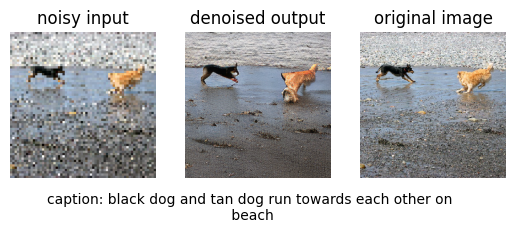

In [167]:
import matplotlib.pyplot as plt
import PIL
im = PIL.Image.open("./output.png")
fig, ax = plt.subplots(1, 3)

ax[0].imshow(control_image)
ax[0].set_title("noisy input")
ax[1].imshow(im)
ax[1].set_title("denoised output")
ax[2].imshow(original_image)
ax[2].set_title("original image")
# display prompt
words = prompt.split()
prompt_with_newlines = ' '.join(words[i] if (i + 1) % 10 != 0 else f'{words[i]}\n' for i in range(len(words)))

fig.text(0.5, 0.15, 'caption: ' + prompt_with_newlines, ha='center')
plt.subplots_adjust(bottom=-0.1)  # Adjust the bottom margin
# fig.suptitle(prompt)
for a in ax:
      a.axis('off')
plt.show()